## Step 1: Import libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline

2023-03-13 09:22:31.623583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 09:22:31.729886: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 09:22:31.733770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 09:22:31.733785: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Step 2: Set Constants

In [2]:
# set constants
SEED = 137

# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 29 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 45 # 35
MAX_HEIGHT = 239 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

## Step 3: Load Data

In [3]:
# load data
df = pd.read_pickle("../raw_data/Grade_ID_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'HGG' else 1)

## Step 4: EDA

In [4]:
print(f"Number of samples: {df['nii'].shape[0]}")
print(f"Negative examples: {df[df['Grade'] == 0].shape}")
print(f"Positive examples: {df[df['Grade'] == 1].shape}")

print("")
print("Single example Shape:")
print(f"Height: {df['nii'][0].shape[0]}")
print(f"Width: {df['nii'][0].shape[1]}")
print(f"Depth: {df['nii'][0].shape[2]}")

Number of samples: 369
Negative examples: (293, 3)
Positive examples: (76, 3)

Single example Shape:
Height: 240
Width: 240
Depth: 155


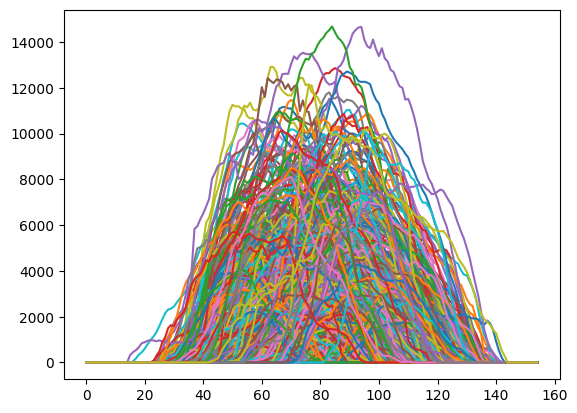

Defined limits: min - 15; max - 143


In [5]:
# code to calculate crop parameters for depth
non_zero = []
min_value = []
max_value = []

for n_image in range(df['nii'].shape[0]):
    image = df['nii'][n_image]
    image_depth_sum = [np.sum(image[:,:,i]) for i in range(image.shape[2])]
    non_zero.append(np.nonzero(image_depth_sum)[0].shape[0])
    min_value.append(np.min(np.nonzero(image_depth_sum)[0]))
    max_value.append(np.max(np.nonzero(image_depth_sum)[0]))
    plt.plot(image_depth_sum)
plt.show()
# here we calculate limits for the depth parameter, but similarly 
# limits can be found for other parameters as well
print(f"Defined depth limits: min - {np.min(min_value)}; max - {np.max(max_value)}")

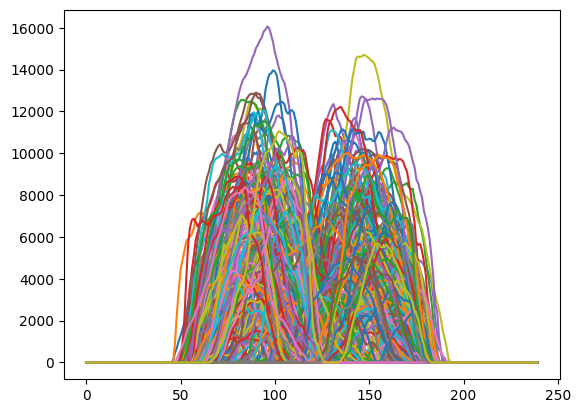

Defined limits: min - 45; max - 239


In [6]:
# code to calculate crop parameters for lenth
non_zero = []
min_value = []
max_value = []

for n_image in range(df['nii'].shape[0]):
    image = df['nii'][n_image]
    image_lenth_sum = [np.sum(image[i,:,:]) for i in range(image.shape[0])]
    non_zero.append(np.nonzero(image_depth_sum)[0].shape[0])
    min_value.append(np.min(np.nonzero(image_lenth_sum)[0]))
    max_value.append(np.max(np.nonzero(image_lenth_sum)[0]))
    plt.plot(image_lenth_sum)
plt.show()
# here we calculate limits for the image_lenth_sum parameter, but similarly 
# limits can be found for other parameters as well
print(f"Defined lenth limits: min - {np.min(min_value)}; max - {np.max(max_value)}")

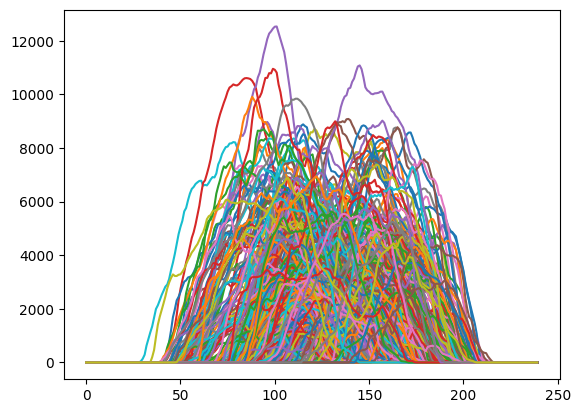

Defined limits: min - 29; max - 215


In [7]:
# code to calculate crop parameters for width
non_zero = []
min_value = []
max_value = []

for n_image in range(df['nii'].shape[0]):
    image = df['nii'][n_image]
    image_width_sum = [np.sum(image[:,i,:]) for i in range(image.shape[1])]
    non_zero.append(np.nonzero(image_width_sum)[0].shape[0])
    min_value.append(np.min(np.nonzero(image_width_sum)[0]))
    max_value.append(np.max(np.nonzero(image_width_sum)[0]))
    plt.plot(image_width_sum)
plt.show()
# here we calculate limits for the image_lenth_sum parameter, but similarly 
# limits can be found for other parameters as well
print(f"Defined width limits: min - {np.min(min_value)}; max - {np.max(max_value)}")

## Step 5: Crop Images and run Augmentation

In [8]:
# crop images
df['nii'] = df['nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = df['nii']
y = df['Grade']

In [9]:
# reshape input data
X = np.array([np.array(val) for val in X])
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [10]:
def rotate_image(X, y, i):
    angles = [-30, -20, -15, -10, -5, 5, 10, 15, 20, 30] # set the list of angles to rotate image
    angle = random.choice(angles) # take the random angle from the list
    rotated_example = ndimage.rotate(X[i], angle, reshape=False) # run image rotation
    X = np.append(X, np.expand_dims(rotated_example, axis=0), axis=0) # append rotated image
    y = y.append(pd.Series([y[i]]), ignore_index=True) # append label
    
    return X, y

In [11]:
# conduct augmentation
for i in range(len(X)):
    # we run augmentation only for positive examples, i.e. y[i] != 0
    if y[i] == 0:
        pass
    else:
        X,y = rotate_image(X, y, i)
        X,y = rotate_image(X, y, i)

/tmp/ipykernel_7556/1348074226.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(pd.Series([y[i]]), ignore_index=True) # append label


In [12]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [13]:
X_train.shape

(416, 194, 186, 128, 1)

In [14]:
y_train.value_counts()

0    234
1    182
dtype: int64

In [15]:
X_train[1]

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


## Step 6: Define Model

In [18]:
#initialize model
def initialize_model(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)):
    model = Sequential()
    
    #Add convo layers to the model
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.3))
    
    #Add layer with activation

    model.add(Dense(1, activation='sigmoid'))

    #Model compilation
    # initial_learning_rate = 0.0001
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
    # )
    optim=Adam(learning_rate= 0.01)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])
    return model

In [17]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 192, 184, 126, 64  1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 96, 92, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 96, 92, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 94, 90, 61, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 47, 45, 30, 64)   0         
 3D)                                                    

2023-03-13 09:45:26.116391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 09:45:26.117338: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 09:45:26.117357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brain-project-cpu): /proc/driver/nvidia/version does not exist
2023-03-13 09:45:26.119606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 7.685603328 Gb


## Step 7: Train Model

In [22]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 8,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/sequential/conv3d/BiasAdd/BiasAddGrad' defined at (most recent call last):
    File "/home/yaoyx001/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/yaoyx001/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7556/3080963370.py", line 2, in <module>
      history = model.fit(X_train, y_train,
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential/conv3d/BiasAdd/BiasAddGrad'
BiasGrad requires tensor size <= int32 max
	 [[{{node gradient_tape/sequential/conv3d/BiasAdd/BiasAddGrad}}]] [Op:__inference_train_function_4847]

: 

In [ ]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

In [ ]:
plot_loss(history)